In [ ]:
import collections
import os
import warnings
from typing import Any, Dict, List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchmeta.modules import MetaBatchNorm2d, MetaConv2d, MetaLinear, MetaModule, MetaSequential
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters
from tqdm import tqdm

from torchmeta.datasets.helpers import fc100
from torchmeta.transforms import Categorical, ClassSplitter
from torchvision.transforms import Compose, Resize, ToTensor
import multiprocessing

try:
    multiprocessing.set_start_method("spawn")
except RuntimeError:
    print("The start method has already been set.")

warnings.filterwarnings("ignore")

In [2]:
from torchmeta.utils.data import Task

def apply_transforms(task, transforms):
    print("Before transformation:", task)
    if isinstance(task, Task):
        task = transforms(task)
    print("After transformation:", task)
    return task

In [3]:
def get_dataloader(
    config: Dict[str, Any]
) -> Tuple[BatchMetaDataLoader, BatchMetaDataLoader, BatchMetaDataLoader]:

    # Set transforms
    train_transforms = Compose([
        Resize(config["image_size"]),
        ToTensor(),
    ])

    val_transforms = Compose([
        Resize(config["image_size"]),
        ToTensor(),
    ])

    # class_splitter = ClassSplitter(shuffle=True, num_train_per_class=config["num_shots"], num_test_per_class=config["test_shots"])

    train_dataset = fc100(
        folder=config["folder_name"],
        shots=config["num_shots"],
        ways=config["num_ways"],
        meta_train=True,
        transform=train_transforms,
        target_transform=Categorical(config["num_ways"]),
        # dataset_transform=class_splitter,
        download=config["download"],
    )
    val_dataset = fc100(
        folder=config["folder_name"],
        shots=config["num_shots"],
        ways=config["num_ways"],
        meta_val=True,
        transform=val_transforms,
        target_transform=Categorical(config["num_ways"]),
        #dataset_transform=class_splitter,
        download=config["download"],
    )
    test_dataset = fc100(
        folder=config["folder_name"],
        shots=config["num_shots"],
        ways=config["num_ways"],
        meta_test=True,
        transform=val_transforms,
        target_transform=Categorical(config["num_ways"]),
        #dataset_transform=class_splitter,
        download=config["download"],
    )

    # train_dataset = class_splitter(train_dataset)
    # val_dataset = class_splitter(val_dataset)
    # test_dataset = class_splitter(test_dataset)
    train_dataloader = BatchMetaDataLoader(train_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1)
    val_dataloader = BatchMetaDataLoader(val_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1)
    test_dataloader = BatchMetaDataLoader(test_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1)

    return train_dataloader, val_dataloader, test_dataloader


In [4]:
class ConvNet(MetaModule):
    def __init__(self, in_channels: int, out_features: int) -> None:
        super(ConvNet, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = 64

        self.convs = MetaSequential(
            self.convBlock(self.in_channels, self.hidden_size, 3),
            self.convBlock(self.hidden_size, self.hidden_size, 3),
            self.convBlock(self.hidden_size, self.hidden_size, 3),
            self.convBlock(self.hidden_size, self.hidden_size, 3),
        )

        self.linear = MetaLinear(self.hidden_size, self.out_features)

    @classmethod
    def convBlock(
        cls, in_channels: int, out_channels: int, kernel_size: int
    ) -> MetaSequential:
        return MetaSequential(
            MetaConv2d(in_channels, out_channels, kernel_size, padding=1, stride=3),
            MetaBatchNorm2d(out_channels, momentum=1.0, track_running_stats=False),
            nn.ReLU(),
        )

    def forward(
        self, x: torch.Tensor, params: Optional[collections.OrderedDict] = None
    ) -> torch.Tensor:
        x_convs = self.convs(x, params=self.get_subdict(params, "convs"))
        prob = self.linear(
            x_convs.flatten(start_dim=1), params=self.get_subdict(params, "linear")
        )
        return prob

In [5]:
def train_maml(
    device: str,
    task_batch_size: int,
    task_batch: Dict[str, List[torch.Tensor]],
    model: ConvNet,
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.Adam,
) -> Tuple[float, float]:
    model.train()

    support_xs = task_batch["train"][0].to(device=device)
    support_ys = task_batch["train"][1].to(device=device)
    query_xs = task_batch["test"][0].to(device=device)
    query_ys = task_batch["test"][1].to(device=device)

    outer_loss = torch.tensor(0.0, device=device)
    accuracy = torch.tensor(0.0, device=device)

    for support_x, support_y, query_x, query_y in zip(
        support_xs, support_ys, query_xs, query_ys
    ):
        support_prob = model(support_x)
        inner_loss = criterion(support_prob, support_y)

        params = gradient_update_parameters(
            model, inner_loss, step_size=0.4, first_order=True
        )

        query_prob = model(query_x, params=params)
        outer_loss += criterion(query_prob, query_y)

        with torch.no_grad():
            _, query_pred = torch.max(query_prob, dim=-1)
            accuracy += torch.mean(query_pred.eq(query_y).float())

    outer_loss.div_(task_batch_size)

    model.zero_grad()
    outer_loss.backward()
    optimizer.step()

    accuracy.div_(task_batch_size)
    return accuracy.item(), outer_loss.item()

In [6]:
def test_maml(
    device: str,
    task_batch_size: int,
    task_batch: Dict[str, List[torch.Tensor]],
    model: ConvNet,
    criterion: nn.CrossEntropyLoss,
) -> Tuple[float, float]:
    model.eval()

    support_xs = task_batch["train"][0].to(device=config["device"])
    support_ys = task_batch["train"][1].to(device=config["device"])
    query_xs = task_batch["test"][0].to(device=config["device"])
    query_ys = task_batch["test"][1].to(device=config["device"])

    outer_loss = torch.tensor(0.0, device=device)
    accuracy = torch.tensor(0.0, device=device)

    for support_x, support_y, query_x, query_y in zip(
        support_xs, support_ys, query_xs, query_ys
    ):
        support_prob = model(support_x)
        inner_loss = criterion(support_prob, support_y)

        params = gradient_update_parameters(
            model, inner_loss, step_size=0.4, first_order=True
        )

        query_prob = model(query_x, params=params)
        outer_loss += criterion(query_prob, query_y)

        with torch.no_grad():
            _, query_pred = torch.max(query_prob, dim=-1)
            accuracy += torch.mean(query_pred.eq(query_y).float())

    outer_loss.div_(task_batch_size)
    accuracy.div_(task_batch_size)
    return accuracy.item(), outer_loss.item()

In [7]:
def save_model(output_folder: str, model: ConvNet, title: str) -> None:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    filename = os.path.join(output_folder, title)

    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("Model is saved in", filename)


def load_model(output_folder: str, model: ConvNet, title: str) -> None:
    filename = os.path.join(output_folder, title)
    model.load_state_dict(torch.load(filename))
    print("Model is loaded")

In [8]:
def print_graph(
    train_accuracies: List[float],
    val_accuracies: List[float],
    train_losses: List[float],
    val_losses: List[float],
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="test_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="test_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [97]:


config = {
    "folder_name": "data/FC1009",
    "num_shots": 5,
    # "test_shots": 5,
    "num_ways": 5,
    "task_batch_size": 15,
    "download": True,
    "image_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_task_batch_train": 1000,  
    "num_task_batch_test": 300,
    "output_folder": "output",     
}





train_dataloader, val_dataloader, test_dataloader = get_dataloader(config)

model = ConvNet(in_channels=3, out_features=config["num_ways"]).to(
    device=config["device"]
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

100%|█| 1000/1000 [02:36<00:00,  6.37it/s, train_accuracy=0.4027, train_loss=1.3874, val_accuracy=0.3173, val_loss=1.62



Train Accuracies - Average: 0.4114, ± 0.0022
Validation Accuracies - Average: 0.2874, ± 0.0016
Model is saved in output\maml_classification.th


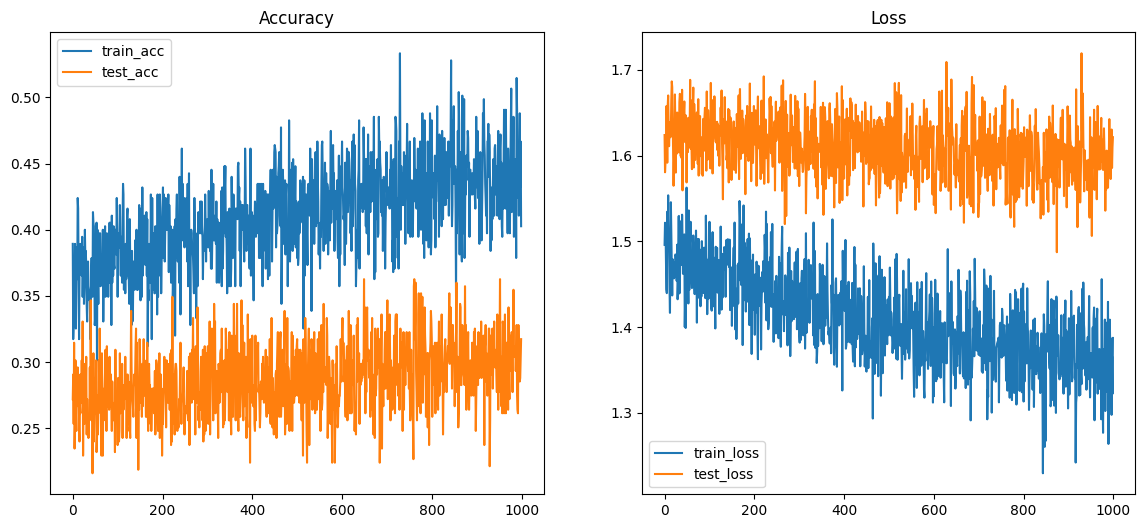

In [98]:
import numpy as np
# 메타-트레이닝
with tqdm(
    zip(train_dataloader, val_dataloader), total=config["num_task_batch_train"]
) as pbar:
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_train"]:
           break

        train_accuracy, train_loss = train_maml(
            device=config["device"],
            task_batch_size=config["task_batch_size"],
            task_batch=train_batch,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
        )
        val_accuracy, val_loss = test_maml(
            device=config["device"],
            task_batch_size=config["task_batch_size"],
            task_batch=val_batch,
            model=model,
            criterion=criterion,
        )

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_accuracy="{0:.4f}".format(train_accuracy),
            val_accuracy="{0:.4f}".format(val_accuracy),
            train_loss="{0:.4f}".format(train_loss),
            val_loss="{0:.4f}".format(val_loss),
        )

train_accuracies_avg = np.mean(train_accuracies)
train_accuracies_std = np.std(train_accuracies)
val_accuracies_avg = np.mean(val_accuracies)
val_accuracies_std = np.std(val_accuracies)

print("\nTrain Accuracies - Average: {:.4f}, ± {:.4f}".format(train_accuracies_avg, 1.96*(train_accuracies_std/np.sqrt(len(train_accuracies)))))
print("Validation Accuracies - Average: {:.4f}, ± {:.4f}".format(val_accuracies_avg, 1.96*(val_accuracies_std/np.sqrt(len(val_accuracies)))))

# 모델 저장하기
save_model(
    output_folder=config["output_folder"], model=model, title="maml_classification.th"
)

print_graph(
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies,
    train_losses=train_losses,
    val_losses=val_losses,
)


In [99]:
# 모델 불러오기
load_model(
    output_folder=config["output_folder"], model=model, title="maml_classification.th"
)

# 메타-테스팅
with tqdm(test_dataloader, total=config["num_task_batch_test"]) as pbar:
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0
    test_accuracies = []  

    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_test"]:
            break

        test_accuracy, test_loss = test_maml(
            device=config["device"],
            task_batch_size=config["task_batch_size"],
            task_batch=test_batch,
            model=model,
            criterion=criterion,
        )

        test_accuracies.append(test_accuracy)  
        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss
        pbar.set_postfix(
            test_accuracy="{0:.4f}".format(sum_test_accuracies / (task_batch_idx + 1)),
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)),
        )

test_accuracy_avg = np.mean(test_accuracies)  # Calculate the average of test_accuracies list
test_accuracy_std = np.std(test_accuracies)  # Calculate the standard deviation of test_accuracies list

# Print the average and 95% confidence interval
print("\nTest Accuracies - Average: {:.4f}, ± {:.4f}".format(test_accuracy_avg, 1.96 * (test_accuracy_std / np.sqrt(len(test_accuracies)))))


Model is loaded


100%|████████████████████████████████████████| 300/300 [00:38<00:00,  7.83it/s, test_accuracy=0.3783, test_loss=1.4463]


Test Accuracies - Average: 0.3783, ± 0.0034


* Refrences
* Book: 모두를 위한 메타러닝
* code : https://github.com/dongminlee94/meta-learning-for-everyone